# CMS Anomaly Detection

## Prepearing data

In [1]:
%matplotlib nbagg
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from joblib import Parallel, delayed

import re

DATA_PATH = 'merged.pickle'

The input files contains preselected features from CMS 2010B open data.
The features were generated from original root in following way:

1. There were selected 3 streams:
  - MiniBias,
  - muons,
  - photons.
2. In each stream 4 "channels" were selected:
  - muons
  - photons
  - PF (particle flows)
  - calo (calorimiter)
3. For each channel from each event  5 quantile particles were selected with redards to thier momentum: quantile $q_i$ corresponds to particle with index closest to $\frac{i}{5}N$, i.e. $q_5$ corresponds to the particle with maximal momentum.
4. Each particle is described by its physical properties: $\eta, \phi, p_T, f_x, f_y, f_z, m$
5. Physical features were aggragated by lumisections, producing:
  - 1, 25, 50, 75, 99 percentiles
  - mean and std
  
As the result each lumisection is described by percentiles, means and stds of distributions of physical features of particles of particular quantiles within particular channel within particular stream.

Some additional features were added like total momentum of all particles of particular channel within event

In [2]:
import cPickle as pickle

with open(DATA_PATH, 'r') as f:
    data = pickle.load(f)

labels = np.load('labels.npy')

In [3]:
### technical columns
not_features = [
    '_luminosityBlock',
    '_run',
    '_instantLumi_minibias',
    '_instantLumi_muons',
    '_instantLumi_photons'
]

### columns that correspond to actual features
features = sorted(set(data.columns) - set(not_features))

In [4]:
np.sum(np.isnan(data.values))

0

In [5]:
for f in features:
    xs = data[f].values

    if np.std(xs) > 0.0:
        data[f] = (xs - np.mean(xs)) / np.std(xs)

In [6]:
np.sum(np.isnan(data.values))

0

In [7]:
lumi = np.maximum(
    np.maximum(data['_instantLumi_minibias'].get_values(), data['_instantLumi_muons'].get_values()),
    data['_instantLumi_photons'].get_values()
)

nonempty = np.where(lumi > 0.0)[0]

In [8]:
data = data.iloc[nonempty]
lumi = lumi[nonempty]
labels = labels[nonempty]

In [9]:
plt.figure(figsize=(8, 8))

plt.hist(
    [lumi[labels == 1.0], lumi[labels == 0.0]],
    label=['Good lumisections', 'Bad lumisections'],
    color=['green', 'red'],
    bins=20,
    histtype='step'
)

plt.legend(loc='upper right')

plt.xlabel('Luminosity')
plt.ylabel('number of lumisections')
plt.show()

<IPython.core.display.Javascript object>

In [10]:
lumi_bad = np.sum(lumi[labels == 0.0])
lumi_good = np.sum(lumi[labels == 1.0])

weights = lumi / np.where(labels == 1.0, lumi_good, lumi_bad)

## Grouping features

Feature set has its own intristic hierarchy. It can be easily seen from their names:
> `<stream>_<particle type>_<physical feature>_<particle quantile>_<feature quantile>`

We are going to build hierarchical Artificial Neural Network, so firstly we must bring features into hierarchy.

In [11]:
### utility functions
def insert(keys, d, f):
    key = keys[0]

    if len(keys) == 1:
        d[key] = f
    else:
        if not d.has_key(key):
            d[key] = dict()
        return insert(keys[1:], d[key], f)

def levels(features, n_levels = 5):
    dicts = [features]

    levels = list()

    for level in range(n_levels):
        levels.append(
            set([ k for d in dicts for k in d ])
        )
    
        dicts = [ d[k] for d in dicts for k in d ]
    return levels
    
def get_feature_groups(feature_list, re_exp):
    """
    Retuns:
    1. hierachical dictionary feature groups -> feature full name
    2. feature levels
    3. unprocessed features
        
    """
    features = dict()
    rest = list()
    n_levels = set()

    for f in feature_list:
        matches = re.findall(re_exp, f)

        if len(matches) == 1:
            insert(matches[0], features, f)
            n_levels.add(len(matches[0]))
        elif len(matches) == 0:
            rest.append(f)
        else:
            raise Exception('Very suspicious feature: %s -> %s' % (f, matches))
    assert len(n_levels) == 1
    return features, levels(features, n_levels=list(n_levels)[0]), rest

In [12]:
def insert_fake_path(d, level, path = 'general'):
    if level == 0:
        return { path : d }
    else:
        r = dict()
        for k in d:
            r[k] = insert_fake_path(d[k], level - 1, path)
        
        return r

### Selecting particles' features:
> `<stream>_<particle type>_<physical feature>_<particle quantile>_<feature quantile>`

In [13]:
particle_f_re = re.compile(r'([a-zA-Z]+)[_]([a-zA-Z]+)[_]([a-zA-Z]+)[_]+(q[12345])[_](\w+)')
particle_features, particle_levels, rest = get_feature_groups(features, particle_f_re)

In [14]:
for level in particle_levels:
    print ' '.join(list(level))

muons minibias photons
muons photons PF calo
phi pt fX fY fZ eta mass
q1 q3 q2 q5 q4
std p99 p1 p25 p75 p50 mean


### Selecting features that belong to a particle type:
> `<stream>_<particle type>_<physical feature>_<feature quantile>`

In [15]:
particle_type_f_re = re.compile(r'([a-zA-Z]+)[_]([a-zA-Z]+)[_]([a-zA-Z]+)[_]+([a-zA-Z0-9]+)')
particle_type_features, particle_type_levels, rest = get_feature_groups(rest, particle_type_f_re)

In [16]:
for level in particle_type_levels:
    print ' '.join(list(level))

muons minibias photons
muons photons PF calo
Pz Px Py
std p99 p1 p25 p75 p50 mean


In [17]:
particle_type_features = insert_fake_path(particle_type_features, level = 2, path='allParticles')

for level in levels(particle_type_features, n_levels=5):
    print ' '.join(list(level))

muons minibias photons
muons photons PF calo
allParticles
Pz Px Py
std p99 p1 p25 p75 p50 mean


The features above are components of momentum of particles of particular type (channel) within event.

### Selecting features specific to events:
> `<stream>_<physical feature>_<feature quantile>`

In [18]:
event_f_re = re.compile(r'([a-zA-Z]+)[_]([a-zA-Z]+)[_]+(\w+)')
event_features, event_levels, rest = get_feature_groups(rest, event_f_re)

In [19]:
for level in event_levels:
    print ' '.join(list(level))

muons minibias photons
instantLumi
std p99 p1 p25 p75 p50 mean


In [20]:
f = insert_fake_path(event_features, level = 1, path='allChannels')
f = insert_fake_path(f, level = 2, path='allParticles')

event_features = f

for level in levels(event_features, n_levels=5):
    print ' '.join(list(level))

muons minibias photons
allChannels
allParticles
instantLumi
std p99 p1 p25 p75 p50 mean


Which are instant luminosity of each event.

In [21]:
rest

['minibias_nEvents',
 'minibias_nonZeroWeights',
 'muons_nEvents',
 'muons_nonZeroWeights',
 'photons_nEvents',
 'photons_nonZeroWeights']

### And finally features specific to lumisection itself:
> `<stream>_<physical feature>_<feature quantile>`

In [22]:
stream_f_re = re.compile(r'([a-zA-Z]+)[_]([a-zA-Z]+)')
stream_features, stream_levels, rest = get_feature_groups(rest, stream_f_re)

In [23]:
for level in stream_levels:
    print ' '.join(list(level))

muons minibias photons
nEvents nonZeroWeights


Number of events and fration of non-zero features for lumisection (all NA's are replaced with zeros).

In [24]:
rest

[]

In [25]:
from collections import defaultdict

def flatten(a_dict):
    for k in a_dict:
        if hasattr(a_dict[k], 'keys'):
            for path, value in flatten(a_dict[k]):
                yield (k, ) + path, value
        else:
            yield (k, ), a_dict[k]

def merge(dicts):
    result = dict()
    for d in dicts:
        for path, value in flatten(d):
            insert(path, result, value)

    return result

def flatten_dict(d):
    r = dict()
    for paths, v in flatten(d):
        k = '_'.join(paths)
        r[k] = v
    return r

def squezze(d, depth = 5, last=2):
    dc = d.copy()

    if depth - 1 == last:
        for k in d:
            dc[k] = flatten_dict(d[k])
        
        return d
    else:
        for k in d:
            dc[k] = squezze(d[k], depth-1, last)
        
        return dc

def group(d, level=2):
    gd = defaultdict(lambda: list())
    for path, k in flatten(d):
        gk = path[:level]
        gd[gk].append(k)
    
    return gd

In [26]:
feature_hierarchy = merge([
    particle_features, particle_type_features, event_features
])

In [27]:
grouped = group(feature_hierarchy, level=2)

In [28]:
[ (g, len(fs)) for g, fs in grouped.items() ]

[((u'muons', u'photons'), 231),
 ((u'minibias', u'PF'), 126),
 ((u'photons', u'photons'), 231),
 ((u'minibias', u'calo'), 266),
 ((u'muons', u'muons'), 266),
 ((u'photons', u'muons'), 266),
 ((u'minibias', 'allChannels'), 7),
 ((u'photons', u'calo'), 266),
 ((u'photons', u'PF'), 126),
 ((u'muons', u'PF'), 126),
 ((u'minibias', u'photons'), 231),
 ((u'muons', 'allChannels'), 7),
 ((u'photons', 'allChannels'), 7),
 ((u'minibias', u'muons'), 266),
 ((u'muons', u'calo'), 266)]

In [29]:
channels_features = dict()

for k in [('muons', 'muons'), ('photons', 'photons'), ('minibias', 'PF'), ('minibias', 'calo')]:
    channels_features[k[1]] = grouped[k]

In [30]:
channels_features['muons'].append('_instantLumi_muons')
channels_features['photons'].append('_instantLumi_photons')

In [31]:
[ (g, len(fs)) for g, fs in channels_features.items() ]

[('muons', 267), ('photons', 232), ('PF', 126), ('calo', 266)]

## Building netwrok

In [32]:
%env THEANO_FLAGS='device=gpu0', 'floatX=float32'

import theano
import theano.tensor as T

from lasagne import *

env: THEANO_FLAGS='device=gpu0', 'floatX=float32'


Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)


In [33]:
shareds = {}

for k in channels_features:
    features = channels_features[k]

    shareds[k] = theano.shared(
        data[features].get_values().astype('float32'),
        name = 'X %s' % k
    )

In [34]:
labels_shared = theano.shared(labels.astype('float32'), 'labels')
weights_shared = theano.shared(weights.astype('float32'), 'weights')

In [35]:
batch_indx = T.ivector('batch indx')

For each feature group we build a dense neural network.
On the one hand, a network should be capable of capturing non-trivial anomalies,
on the other hand a number of training samples is small. It is the reason why heavy dropout is applied for each layer.

Nevertheless, we should expect low bias due to dropout, since it is believed that not all features should interact
directly within one unit. For example, it is reasonable that momentum features do not mix with angular ones within one unit. Thus structure of weights should be sparse, which is one of the effects of the dropout regularization.

> Note that the output layers are also corrupted by dropout. This ensures that all subnetworks contribute to the final desicion and do not distribute responsobilities for different kind of anomalies detectable from a subset of channels.
> For example, there are 2 kinds of anomalies detectable from both photons and muons channels.
> In principle, photon network can learn to detect first kind anomaly while moun one takes care of the second one.
> Dropout forces both networks to detect both kinds of anomalies, since predictions of both networks are no longer reliable and and all networks shift torwards predicting all possible anomalies within their channels.

In [36]:
def build_network(shared, batch_indx, num_units = (50, 10)):
    n_features = shared.get_value().shape[1]
    X_batch = shared[batch_indx]

    input_layer = layers.InputLayer(shape=(None, n_features), input_var=X_batch)
    
    net = input_layer
    
    for n in num_units:
        net = layers.DenseLayer(net, num_units=n, nonlinearity=nonlinearities.softplus)
        net = layers.DropoutLayer(net, p=0.25, rescale=True)
    
    net = layers.DenseLayer(net, num_units=1, nonlinearity=nonlinearities.tanh)
    net = layers.DropoutLayer(net, p = 0.1, rescale=False)
    
    det_prediction = T.flatten(layers.get_output(net, deterministic=True))
    train_prediction = T.flatten(layers.get_output(net, deterministic=False))
    
    return net, det_prediction, train_prediction

In [37]:
networks = {}
det_predictions = {}
train_predictions = {}

for k in shareds:
    shared = shareds[k]

    net, det_prediction, train_prediction = build_network(shared, batch_indx, num_units=(100, 20))
    
    det_predictions[k] = det_prediction
    train_predictions[k] = train_prediction

    networks[k] = net

In [38]:
get_get_predictions = {}
get_stochastic_predictions = {}

for k in det_predictions:
    get_get_predictions[k] = theano.function([batch_indx], det_predictions[k])
    get_stochastic_predictions[k] = theano.function([batch_indx], train_predictions[k])

In [39]:
def sum_(xs):
    return reduce(lambda a, b: a + b, xs)

def min_(xs):
    return reduce(T.minimum, xs)

train_global_prediction = T.nnet.sigmoid(3 * min_(train_predictions.values()))
det_global_prediction = T.nnet.sigmoid(3 * min_(det_predictions.values()))

In [40]:
labels_batch = labels_shared[batch_indx]
weights_batch = weights_shared[batch_indx]

In [41]:
reg = reduce(lambda a, b: T.maximum(a, b), [
    regularization.regularize_network_params(networks[k], penalty=regularization.l2)
    for k in networks
])

In [42]:
c_reg = T.fscalar('c reg')

In [43]:
log_losses = -((1 - labels_batch) * T.log(1 - train_global_prediction) + labels_batch * T.log(train_global_prediction))

pure_loss = T.sum(weights_batch * log_losses) / T.sum(weights_batch)

loss = pure_loss +  c_reg * reg

In [44]:
params = reduce(lambda a, b: a + b, [
        layers.get_all_params(net)
        for net in networks.values()
])

learning_rate = T.fscalar('learning rate')
upd = updates.adadelta(loss, params, learning_rate = learning_rate)

In [45]:
train = theano.function([batch_indx, c_reg, learning_rate], [pure_loss, loss], updates=upd)
get_loss = theano.function([batch_indx], pure_loss)

get_prediction = theano.function([batch_indx], det_global_prediction)
get_train_prediction = theano.function([batch_indx], train_global_prediction)

In [46]:
from sklearn.model_selection import train_test_split

In [47]:
indx_train, indx_test = train_test_split(np.arange(data.shape[0], dtype='int32'), stratify=labels, test_size=0.1)

In [48]:
def batch_stream(X, batch_size=32):
    indx = np.random.permutation(X.shape[0])
    n_batches = X.shape[0] / batch_size

    for i in xrange(n_batches):
        batch_indx = indx[(i * batch_size):(i * batch_size + batch_size)]
        yield X[batch_indx]

In [49]:
from crayimage.utils import NNWatcher

<IPython.core.display.Javascript object>


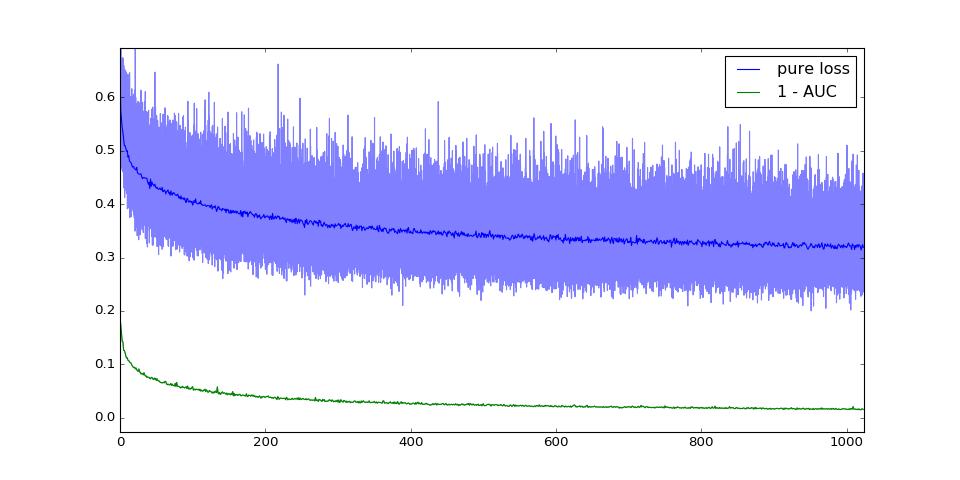

In [50]:
watcher = NNWatcher(labels=('pure loss', '1 - AUC'), colors=('blue', 'green'))

In [51]:
from sklearn.metrics import roc_auc_score
n_epoches = 1024
batch_size = 256
n_batches = indx_train.shape[0] / batch_size

pure_losses = np.zeros(shape=(n_epoches, n_batches), dtype='float32')
validation_loss = np.zeros(shape=(n_epoches, 1), dtype='float32')

lr = np.float32(1.0)
c_reg = np.float32(5.0e-6)

for epoch in xrange(n_epoches):
    for i, idx in enumerate(batch_stream(indx_train, batch_size=batch_size)):
        pure_losses[epoch, i], _ = train(idx, c_reg, lr)
    
    mean_predictions = np.mean(np.array([
        get_train_prediction(indx_train)
        for _ in range(16)
    ]), axis=0)

    validation_loss[epoch] = 1 - roc_auc_score(
        labels[indx_train],
        mean_predictions,
        sample_weight=weights[indx_train]
    )
    
    watcher.draw(
        pure_losses[:(epoch + 1)],
        validation_loss[:(epoch + 1)]
    )

In [52]:
common_proba = get_prediction(indx_test)

mean_proba = np.mean(np.array([
        get_train_prediction(indx_test)
        for _ in range(128)
]), axis=0)

## Classifier evaluation

<IPython.core.display.Javascript object>


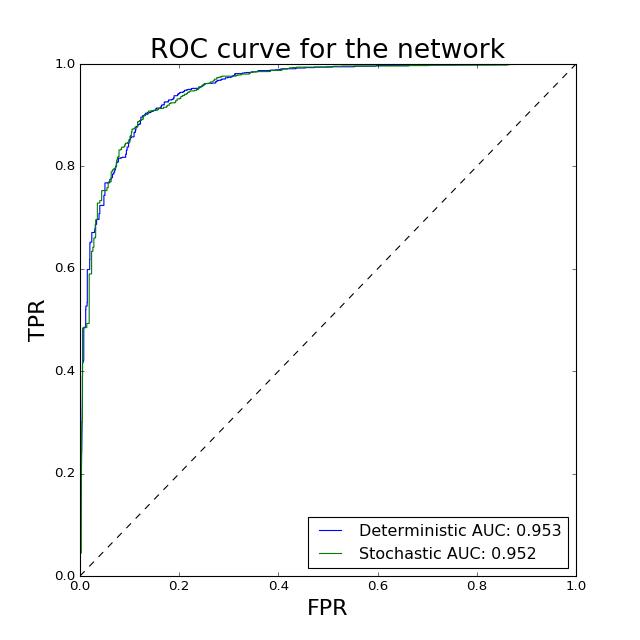

In [56]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], '--', color='black')

fpr, tpr, _ = roc_curve(labels[indx_test], common_proba, sample_weight=weights[indx_test])
auc_score = auc(fpr, tpr, reorder=True)
plt.plot(fpr, tpr, label='Deterministic AUC: %.3lf' % auc_score)

fpr, tpr, _ = roc_curve(labels[indx_test], mean_proba, sample_weight=weights[indx_test])
auc_score = auc(fpr, tpr, reorder=True)
plt.plot(fpr, tpr, label='Stochastic AUC: %.3lf' % auc_score)

plt.legend(loc='lower right')
plt.title('ROC curve for the network', fontsize=24)
plt.xlabel('FPR', fontsize=20)
plt.ylabel('TPR', fontsize=20)
plt.show()

In [54]:
probas = {}

for k in ['muons', 'photons', 'PF', 'calo']:
    feautures = channels_features[k]
    probas[k] = get_get_predictions[k](indx_test)

<IPython.core.display.Javascript object>


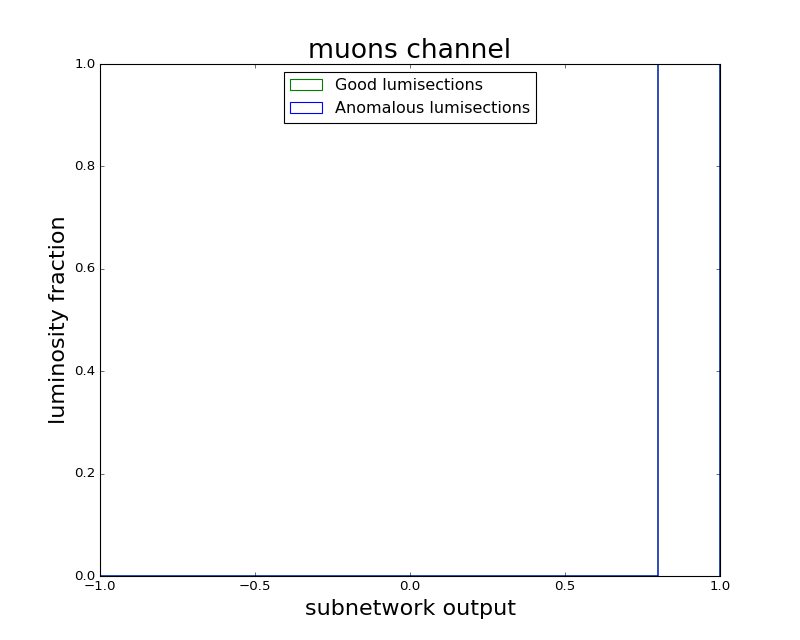

<IPython.core.display.Javascript object>


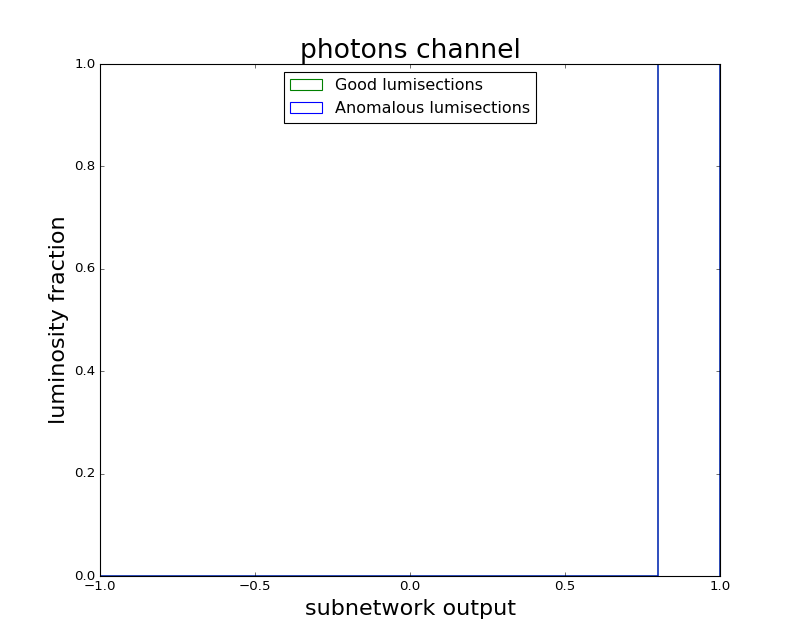

<IPython.core.display.Javascript object>


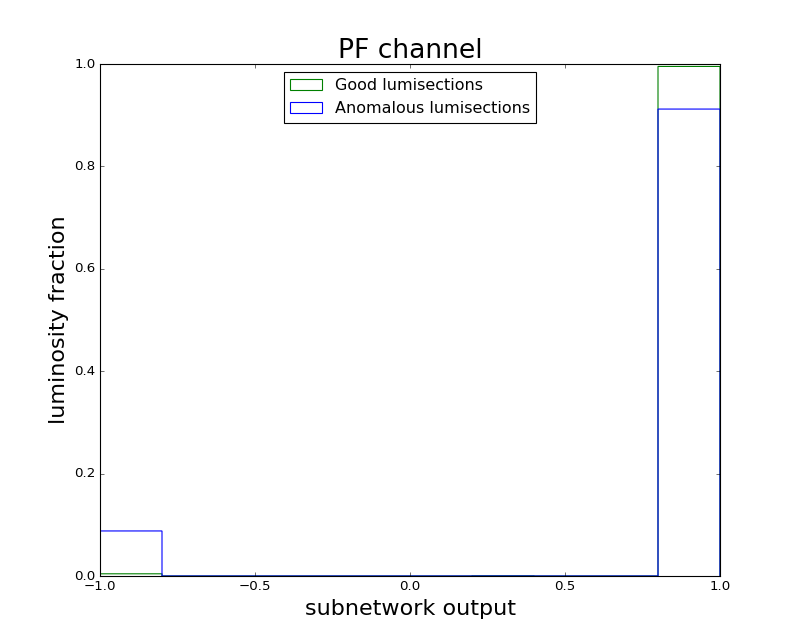

<IPython.core.display.Javascript object>


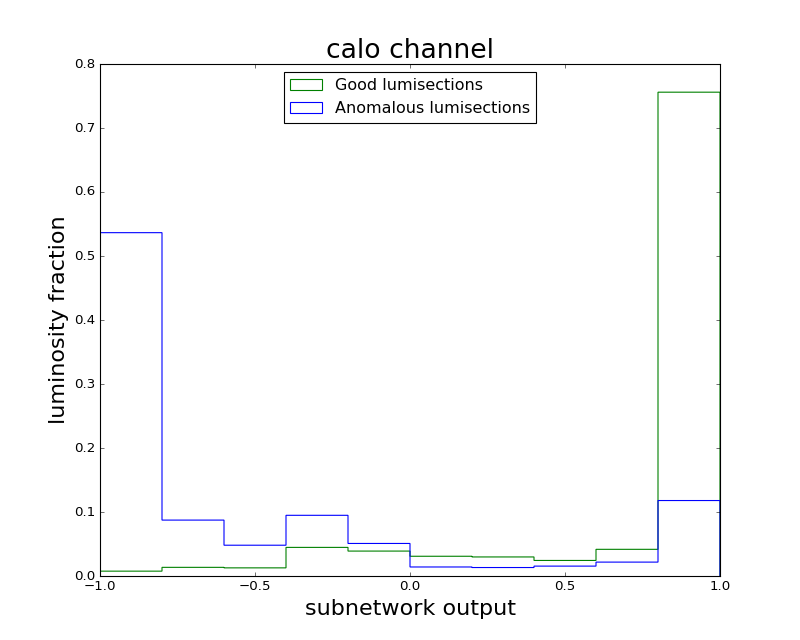

In [63]:
for k in ['muons', 'photons', 'PF', 'calo']:
    proba = probas[k]
    
    plt.figure(figsize=(10, 8))
    plt.hist([
            proba[labels[indx_test] == 0.0],
            proba[labels[indx_test] == 1.0]
    ],bins=10, range=(-1, 1), weights=[
        weights[indx_test][labels[indx_test] == 0.0] / np.sum(weights[indx_test][labels[indx_test] == 0.0]),
        weights[indx_test][labels[indx_test] == 1.0] / np.sum(weights[indx_test][labels[indx_test] == 1.0])
    ], histtype='step', label=['Anomalous lumisections', 'Good lumisections'])
    plt.legend(loc='upper center')
    plt.title('%s channel' % k, fontsize=24)
    plt.ylabel('luminosity fraction', fontsize=20)
    plt.xlabel(r'subnetwork output', fontsize=20)
    plt.show()

In [60]:
calo_net = networks['calo']

<IPython.core.display.Javascript object>


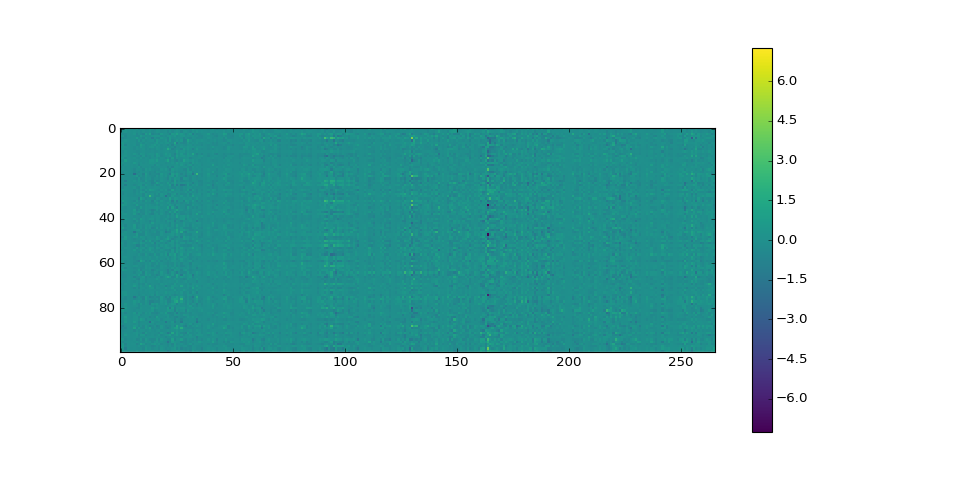

<IPython.core.display.Javascript object>


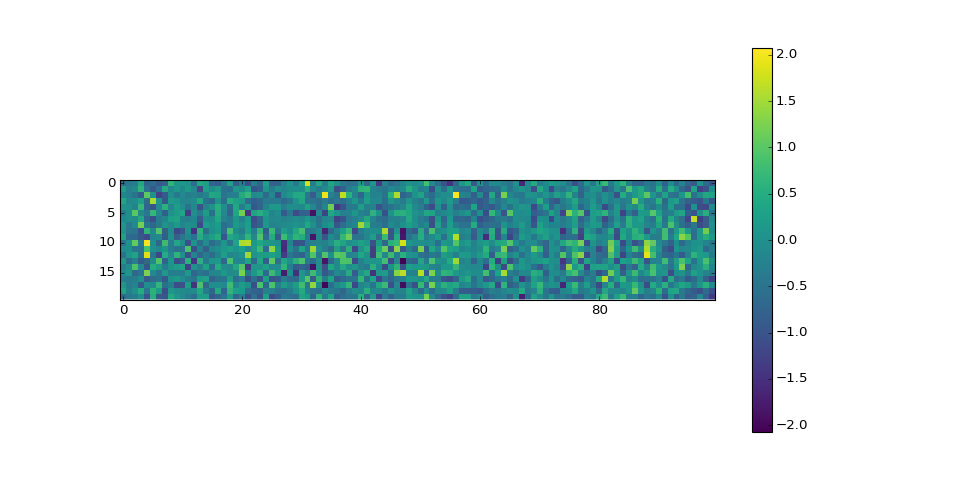

<IPython.core.display.Javascript object>


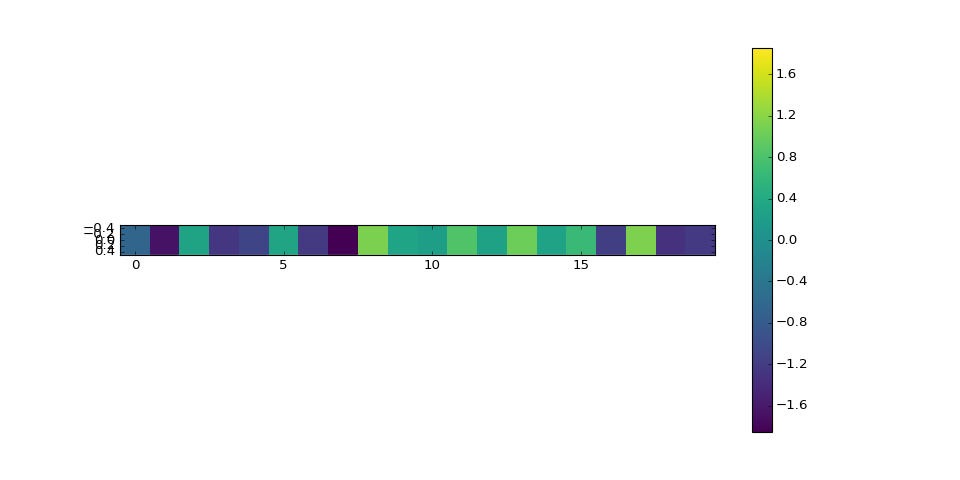

In [64]:
for p in layers.get_all_param_values(calo_net):
    if p.ndim == 2:
        plt.figure(figsize=(12, 6))
        vmin = -np.max(np.abs(p))
        vmax = np.max(np.abs(p))
        plt.imshow(p.T, interpolation='none', cmap=plt.cm.viridis, vmin=vmin, vmax=vmax)
        plt.colorbar()
        plt.show()